In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr
import statsmodels.api as sm
import time

matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.style.use('seaborn-v0_8')

In [2]:
# PRCP in [mm]

df = pd.read_csv('../data/padova/PADOVA_1725_2022_PRCPdaily_reorganize.csv')
df['DATE'] = pd.to_datetime((df.YY*10000+df.MM*100+df.DD).apply(str),format='%Y%m%d')
df = df.drop(['DD', 'MM', 'YY'], axis=1)[['DATE', 'PRCP']]
df.head()

,DATE,PRCP
0,1725-01-01,0.0
1,1725-01-02,0.0
2,1725-01-03,0.0
3,1725-01-04,0.0
4,1725-01-05,0.0


In [3]:
study_periods = [('1725-01-01','1764-12-31'),('1768-01-01','1807-12-31'),('1841-01-01','1880-12-31'),('1887-01-01','2021-12-31')]
df1 = df[(df['DATE'] >= study_periods[0][0]) & (df['DATE'] <= study_periods[0][1])]
df2 = df[(df['DATE'] >= study_periods[1][0]) & (df['DATE'] <= study_periods[1][1])]
df3 = df[(df['DATE'] >= study_periods[2][0]) & (df['DATE'] <= study_periods[2][1])]
df4 = df[(df['DATE'] >= study_periods[3][0]) & (df['DATE'] <= study_periods[3][1])]
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.head()

,DATE,PRCP
0,1725-01-01,0.0
1,1725-01-02,0.0
2,1725-01-03,0.0
3,1725-01-04,0.0
4,1725-01-05,0.0


In [4]:
def decluster(df, noise_lag = 10, noise_prob = 0.9, max_lag = 30):
    '''------------------------------------------------------------
    Decluster rainfall time series on a YEARLY BASIS. Eliminate the non-zero value within a correlation window
    Once correlation time scale is computed, running windows with its size are selected.
    within each of them, I only keep the largest event observed.
    :param sample: the time series to be declustered.
    :param noise_lag: minimum lag at which I consider the ACF to be noise (defult = 10)
    :param noise_prob: assume as noise correlation the 75% percentile of values beyond noise_lag
    :param max_lag: max lag used to compute the noise level (default = 30)
    :return:
    -> dec_df  -> a new declustered dataframe

    Note that ACF is meaningless in case long series of 0 in the TS. Care should be taken in such cases.
    --------------------------------------------------------------'''
    dec_df = df.copy()
    for year in range(df['DATE'].iloc[0].year, df['DATE'].iloc[-1].year + 1):
        sample = dec_df.loc[dec_df['DATE'].dt.year==year, 'PRCP'].values
        if sample.any(): # Check if sample is not empty
            dec_df.loc[dec_df['DATE'].dt.year==year, 'PRCP'] = yearly_decluster(sample, noise_lag, noise_prob, max_lag)[0]
    return dec_df

def yearly_decluster(sample, noise_lag = 10, noise_prob = 0.9, max_lag = 30):
    '''------------------------------------------------------------
    Decluster YEARLY rainfall time series. Eliminate the non-zero value within a correlation window
    Once correlation time scale is computed, running windows with its size are selected.
    within each of them, I only keep the largest event observed.
    :param sample: the time series to be declustered.
    :param noise_lag: minimum lag at which I consider the ACF to be noise (defult = 10)
    :param noise_prob: assume as noise correlation the 75% percentile of values beyond noise_lag
    :param max_lag: max lag used to compute the noise level (default = 30)
    :return:
    -> dec_sample -> declustered time series
    -> dec_lag    -> running lag window size in which I only keep the maximum

    Note that ACF is meaningless in case long series of 0 in the TS. Care should be taken in such cases.
    --------------------------------------------------------------'''
    det_sample = sample.copy()
    time_corr = sm.tsa.acf(sample, nlags=max_lag)

    # ACF is assumed to be noise for k >= noise_lag 
    noise = time_corr[noise_lag:]
    sorted_noise = np.sort(noise)
    num_noise = np.size(noise)
    Fi = (np.arange(num_noise)+1)/(num_noise+1) # non exceedance
    mypos = np.argmin( np.abs(Fi-noise_prob))
    noise_level = sorted_noise[mypos]

    # first crossing of noise level
    racf = time_corr - noise_level
    # now find its first zero crossing
    zero_crossings = np.where(np.diff(np.sign(racf)))[0]

    # Correlation window size
    dec_par = zero_crossings[0] 
    
    # roll the sample array with a lookback window of dec_par+1
    s_rolled = np.lib.stride_tricks.sliding_window_view(sample, dec_par + 1)
    out = np.zeros(s_rolled.shape)
    out[np.arange(len(s_rolled)), np.argmax(s_rolled, axis=1)] = 1

    # Selecting only maximum of rolling window
    for iis in range(np.size(sample)-dec_par):
        window = sample[iis:iis+dec_par+1]
        loc_max = np.max(window)
        for iie in range(np.size(window)):
            if window[iie] < loc_max:
                det_sample[iis + iie] = 0
        
    return det_sample, dec_par



In [5]:
start_time = time.time()
dec_df = decluster(df)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.0650908946990967 seconds ---


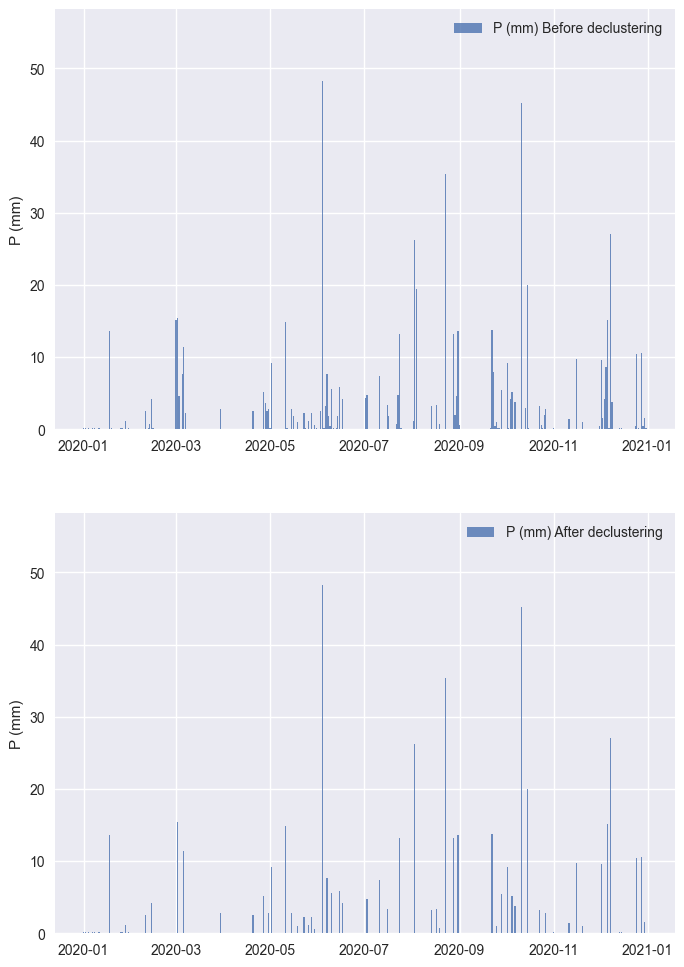

In [6]:
fig, axs = plt.subplots(2, figsize=(8, 12))

year = 2020
original_TS = df.loc[df['DATE'].dt.year == year, 'PRCP']
declustered_TS = dec_df.loc[dec_df['DATE'].dt.year == year, 'PRCP']
t = df.loc[df['DATE'].dt.year == year, 'DATE']

# Plotting precipitation
axs[0].bar(t, original_TS, alpha=0.8, label='P (mm) Before declustering')
axs[1].bar(t, declustered_TS, alpha=0.8, label='P (mm) After declustering')

# Styling the axis
for ax in axs:
    ax.set_ylim(original_TS.min(), original_TS.max()+10)
    ax.set_ylabel('P (mm)')
    ax.grid(True)
    ax.legend()